In [1]:
import os
os.chdir("../../..")
import deepof.data

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

# DeepOF unsupervised pipeline: exploring the behavioral space

##### Tutorial index:
    
* Brief introduction to unsupervised analysis.
* Load your previous project.
* Running an unsupervised analysis with default parameters.
* Understanding the different available models.
* Cluster number selection.
* Temporal and global embeddings.
* Global separation dynamics.
* Exploring cluster enrichment across conditions.
* Exploring cluster dynamics across conditions.
* Interpreting clusters using SHAP.
* Exporting cluster video snippets.

### Brief introduction to unsupervised analysis

### Load your previous project

In [3]:
my_deepof_project = deepof.data.load_project("./deepof_FC_project_files/")

import pickle
with open("./deepof_FC_project_files/Coordinates/FC_dataset_experimental_conditions.pkl", "rb") as handle:
    exp_conditions = pickle.load(handle)
my_deepof_project._exp_conditions = exp_conditions

# Update project path to a local path
my_deepof_project._project_path = ""

In [4]:
# THIS SHOULD BE THE LAST SECTION OF THE FIRST TUTORIAL!

# Check scales across animals. Can we detect to which animal a given time series belongs to?
# Once happy with a solution, check that all animals show comparable cluster interpretations.

# Add preprocessing options to include multiple animals, concatenated and together in a graph

# tt = my_deepof_project.get_coords(center="Center", align="Spine_1")
# tt, _ = tt.preprocess(
#     window_size=13,
#     window_step=1,
#     test_videos=1,
#     scale="standard",
#     handle_ids="split", # "concat" uses bps from != animals as features, "split"
# )

In [5]:
# SAME HERE: Last section of the last tutorial should explore tensor and graph preprocessing
from deepof.utils import connect_mouse_topview
import networkx as nx

pp, G, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
   # animal_id="B",
    center="Center",
    align="Spine_1",
    window_size=13,
    window_step=1,
    preprocess=True,
    scale="standard"
)

adj = nx.adjacency_matrix(G).todense()

/var/folders/wf/msmt6cvx5xl9t0p2qjd1tn65jtl6l8/T/ipykernel_60354/2788945428.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).todense()


In [6]:
#What happens if we use a two-stage normalization approach?
# 1) Normalize within animals to get rid of body size effects
# 2) Normalize across animals to have similar stats across animals, and get the same clusters regardless of the animal
# ID.

### Running an unsupervised analysis with default parameters

In [7]:
%%time
cons = my_deepof_project.deep_unsupervised_embedding(
    pp,
    adjacency_matrix=adj,
    embedding_model="VaDE",
    epochs=2,
    encoder_type="recurrent",
    n_components=10,
    latent_dim=4,
    kl_warmup=10,
    kl_annealing_mode="linear",
    batch_size=1024,
    kmeans_loss=0.0,
    reg_cat_clusters=0.0,
    pretrained="deepof_FC_project_files/Trained_models/train_models/trained_weights/deepof_unsupervised_VaDE_recurrent_encodings_input_type=graph_kmeans_loss=0.0_encoding=4_k=10_run=1_final_weights.h5",
)

2023-01-29 18:37:11.349718: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-01-29 18:37:11.349734: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-01-29 18:37:11.351764: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
/Users/lucas_miranda/Library/Caches/pypoetry/virtualenvs/deepof-qxwF8hwh-py3.9/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
2023-01-29 18:37:34.594519: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method

CPU times: user 34.2 s, sys: 16.2 s, total: 50.4 s
Wall time: 35 s


In [8]:
# Load results
# import pickle
# with open(
#     "./deepof_FC_project_files/Trained_models/train_models/deepof_unsupervised_VaDE_encoder_recurrent_encodings_input=graph_k=10_latdim=4_changepoints_False_kmeans_loss=0.0_run=1.pkl", "rb"
# ) as handle:
#     embeddings, soft_counts, breaks = pickle.load(handle)

### Understanding the different available models

In [9]:
cons.vade.summary()

Model: "VaDE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 13, 33)]     0           []                               
                                                                                                  
 encoder_edge_features (InputLa  [(None, 13, 11)]    0           []                               
 yer)                                                                                             
                                                                                                  
 recurrent_encoder (Functional)  (None, 4)           3484        ['input_7[0][0]',                
                                                                  'encoder_edge_features[0][0]']  
                                                                                               

### Cluster number selection

### Visualizing temporal and global embeddings

In [10]:
# INCORPORATE AS A METHOD FOR EACH MODEL
embeddings, soft_counts, breaks = deepof.model_utils.embedding_per_video(my_deepof_project, to_preprocess, cons)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:58<00:00,  4.47s/it]


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


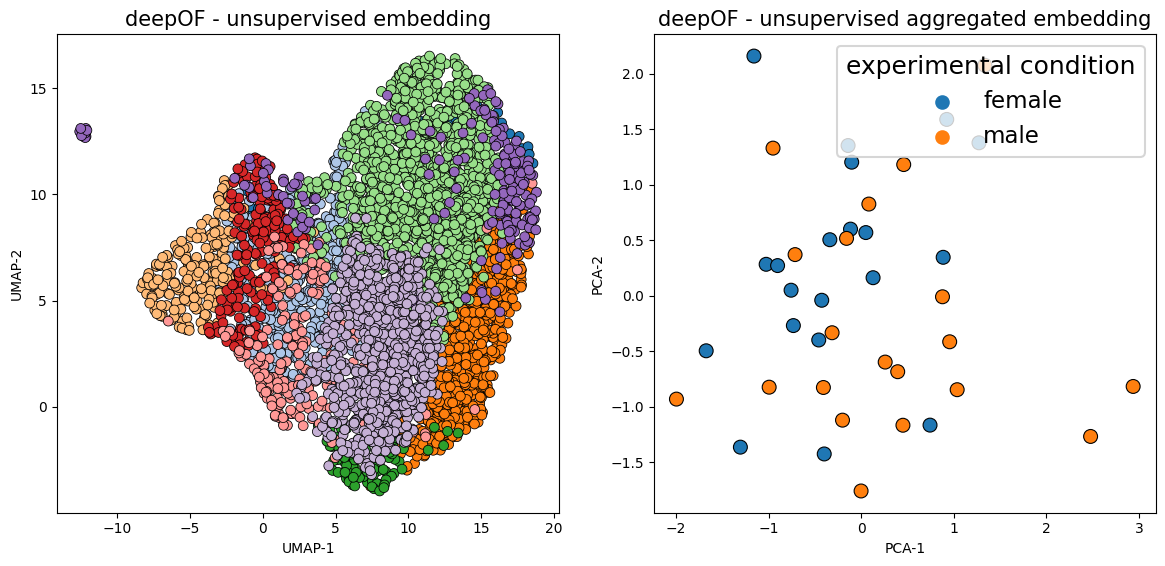

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_embeddings(
    my_deepof_project, 
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments=False,
    samples=100,
    ax=ax1,
    save=False, # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments="time on cluster",
    exp_condition="Sex",
    show_aggregated_density=False,
    ax=ax2,
    save=False, # Set to True, or give a custom name, to save the plot,
)

plt.tight_layout()
plt.show()

In [12]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=embeddings,
  #  animal_id="B",
    cluster_assignments=soft_counts,
    experiment_id="Test_10_FA_JB07_cut",
    frame_limit=150,
    selected_cluster=5,
    dpi=50,
    center="Center",
    #align="Spine_1",
    #embedding=[emb_B, emb_W],
)

html = display.HTML(video)
display.display(html)
plt.close()

### Global separation dynamics

In [13]:
# from scipy.signal import savgol_filter

# @interact()
# def plot_distance_between_conditions(
#     # Model selection parameters
#     animal_setting=["SI", "OF"],
#     cluster_number=IntSlider(min=5, max=26, value=7),
#     run_id=IntSlider(min=0, max=9, value=8),
#     embedding_aggregation_method=["time_on_cluster", "mean", "median"],
#     distance_metric=["wasserstein", "auc"],
# ):

#     if animal_setting == "OF":
#         csds_project = csds_OF_project

#     elif animal_setting == "SI":
#         csds_project = csds_SI_project

#     # Get curve
#     emb_path = "./CSDS_{}_model_selection_NatComm/CSDS_{}_model_selection/deepof_unsupervised_VQVAE_encodings_input=coords_k={}_latdim=16_kmeans_loss=0.0_run={}.pkl".format(
#         animal_setting,
#         animal_setting,
#         cluster_number,
#         run_id,
#     )


#     with open(emb_path, "rb") as handle:
#         embedding, soft_counts, breaks = pickle.load(handle)

#     # Get distance between distributions across the growing window
#     distance_array = deepof.post_hoc.condition_distance_binning(
#         embedding,
#         soft_counts,
#         breaks,
#         csds_project.get_exp_conditions,
#         10 * 25,
#         14500,
#         25,
#         agg=embedding_aggregation_method,
#         metric=distance_metric,
#     )

#     optimal_bin = np.argmax(savgol_filter(distance_array, 10, 2)) + 10
    
#     distance_per_bin = deepof.post_hoc.condition_distance_binning(
#         embedding,
#         soft_counts,
#         breaks,
#         csds_project.get_exp_conditions,
#         10 * 25,
#         14500,
#         optimal_bin * 25,
#         agg=embedding_aggregation_method,
#         scan_mode="per-bin",
#         metric=distance_metric,
#     )

#     # Concatenate both arrays and create a px compatible data frame
#     distance_df = pd.DataFrame(
#         {
#             animal_setting: distance_array,
#             "Time": np.linspace(10, 600, len(distance_array)),
#         }
#     ).melt(
#         id_vars=["Time"],
#         value_name=distance_metric,
#         var_name="experimental setting",
#     )

#     bin_distance_df = pd.DataFrame(
#         {
#             animal_setting: distance_per_bin,
#             "Time": np.linspace(
#                 optimal_bin, 600, len(distance_per_bin)
#             ),
#         }
#     ).melt(
#         id_vars=["Time"],
#         value_name=distance_metric,
#         var_name="experimental setting",
#     )

#     # Plot the obtained distance array
#     fig = px.line(
#         distance_df,
#         x="Time",
#         y=distance_metric,
#         title="deepOF - distance between conditions",
#         template="simple_white",
#         height=350,
#         width=900,
#         color_discrete_sequence=["#d6dbd2"]
#     )
    
#     fig.update_xaxes(title_font=dict(size=20, family='Arial'), tickfont_size=15)
#     fig.update_yaxes(title_font=dict(size=20, family='Arial'), tickfont_size=15)

#     fig.add_traces(
#         list(
#             px.line(
#                 bin_distance_df, x="Time", y=distance_metric, template="simple_white",
#                 color_discrete_sequence=["#1B998B"], markers=True,
#             ).select_traces()
#         )
#     )
    
#     distance_df[distance_metric] = savgol_filter(distance_array, 10, 2)
    
#     fig.add_trace(
#         go.Scatter(
#             x=distance_df["Time"], y=distance_df[distance_metric],
#             line=dict(color='#373737', width=1), mode="lines", name=""
#         )
#     )

#     fig.show()
#     # fig.write_image("CSDS_figures/CSDS_SI_bin_selection.pdf")

# hide_toggle()

### Exploring cluster enrichment across conditions

In [14]:
my_deepof_project.get_exp_conditions['Test_10_FA_JB06_2_cut'].Sex.values[0] == "female"

True

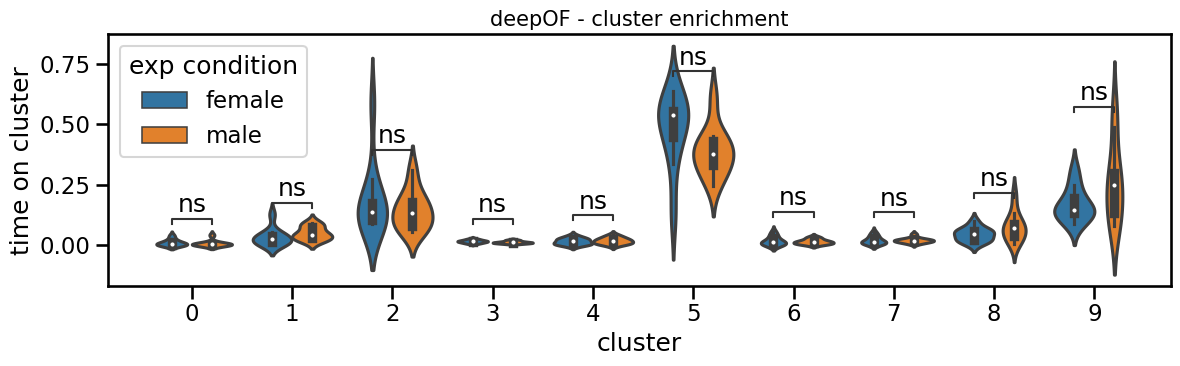

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

deepof.visuals.plot_cluster_enrichment(
    my_deepof_project,
    {key:emb for key, emb in embeddings.items() if my_deepof_project.get_exp_conditions[key].Condition.values[0] == "Nonstressed"},
    {key:sfc for key, sfc in soft_counts.items() if my_deepof_project.get_exp_conditions[key].Condition.values[0] == "Nonstressed"},
    {key:brk for key, brk in breaks.items() if my_deepof_project.get_exp_conditions[key].Condition.values[0] == "Nonstressed"},
    normalize=True,
    bin_size=1000,
    bin_index=1,
    add_stats="Mann-Whitney",
    exp_condition="Sex",
    verbose=False,
    ax=ax,
)

### Exploring cluster dynamics across conditions

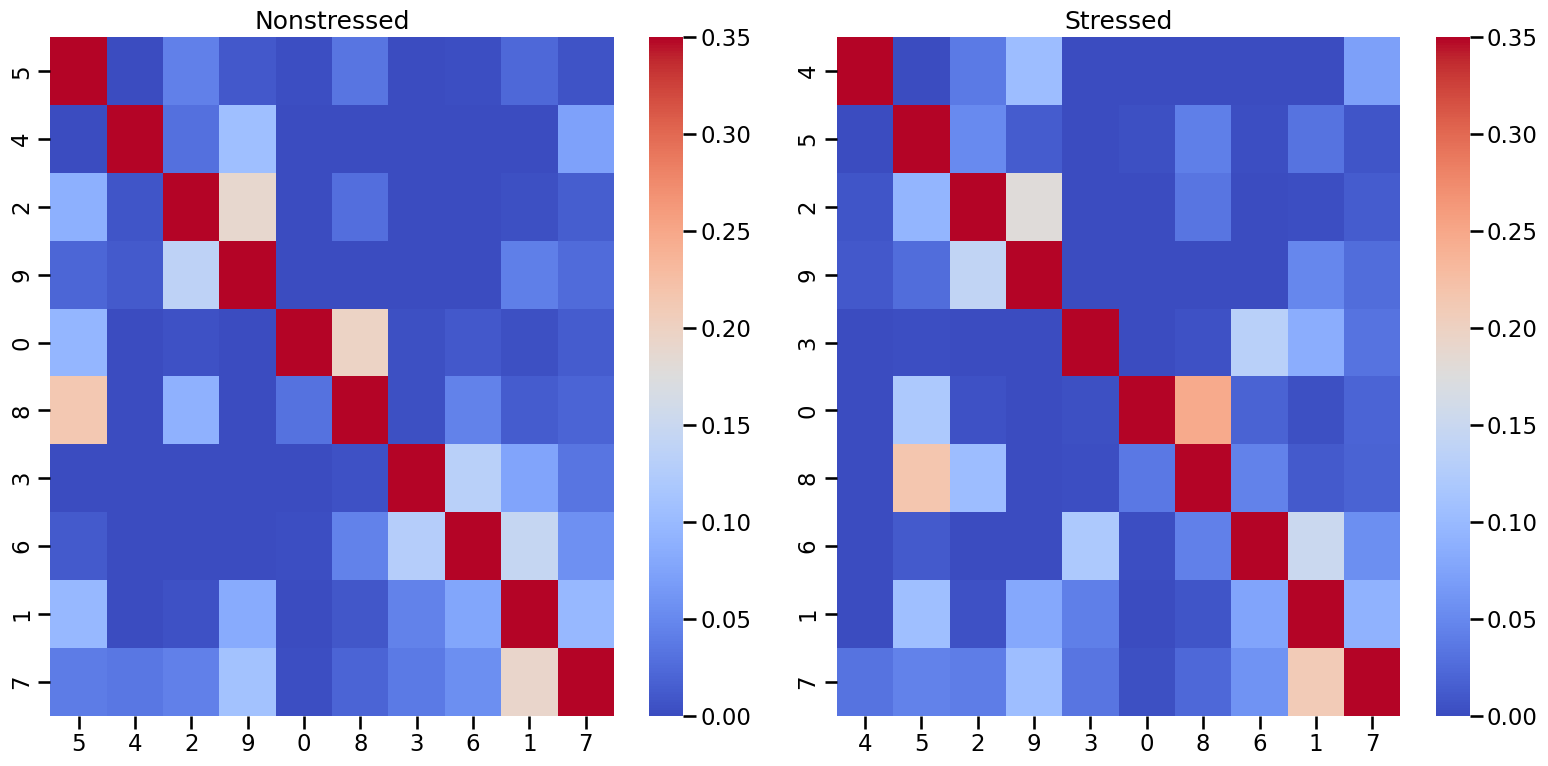

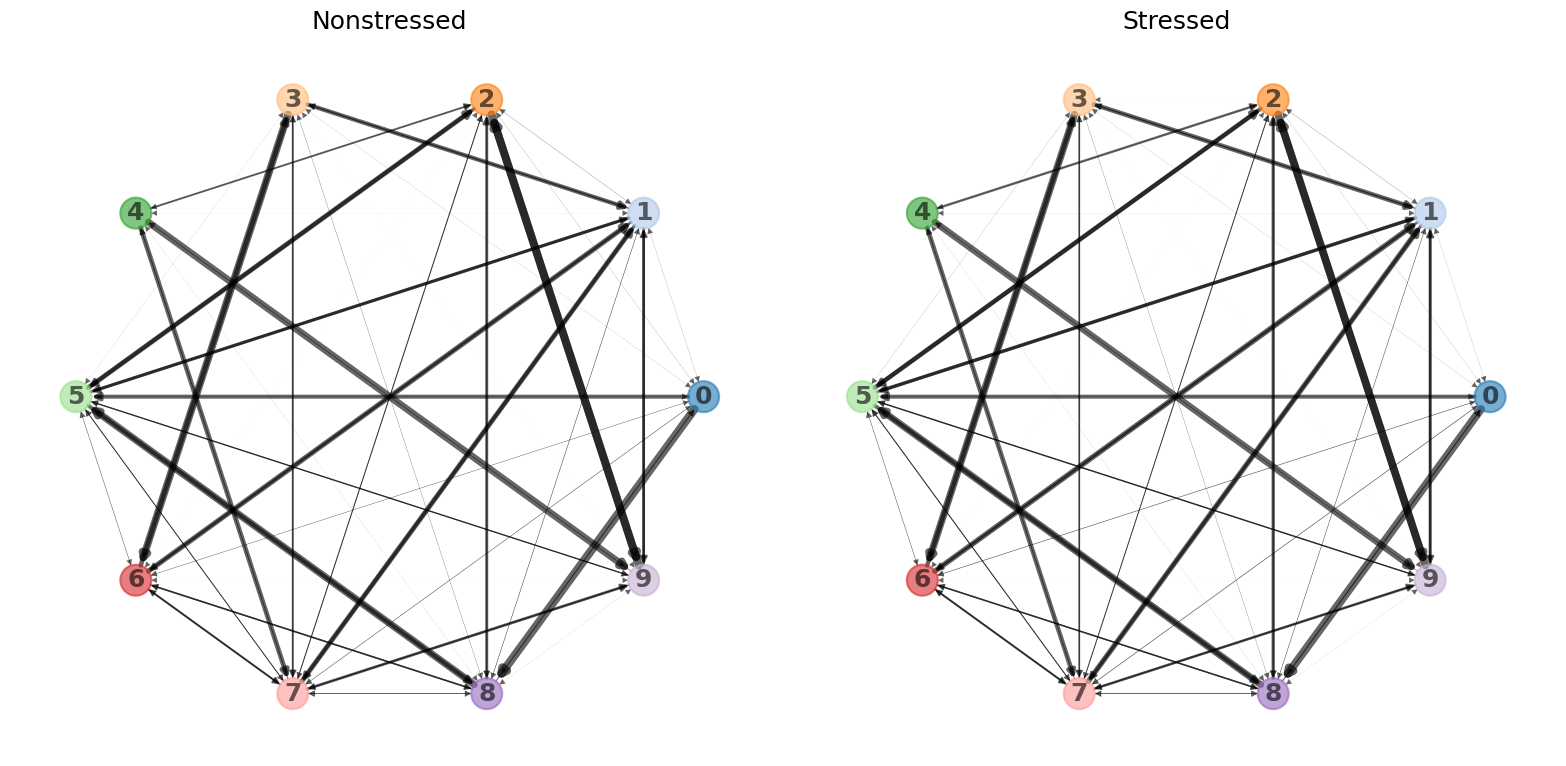

In [16]:
# Transition matrices and heatmaps
deepof.visuals.plot_transitions(
    my_deepof_project,
    embeddings,
    soft_counts,
   # cluster=False,
    visualization="heatmaps",
    exp_condition="Condition",
)

deepof.visuals.plot_transitions(
    my_deepof_project,
    embeddings,
    soft_counts,
    visualization="networks",
    silence_diagonal=True,
    exp_condition="Condition",
)

# TODO:

# Add option to use umap location on network plots

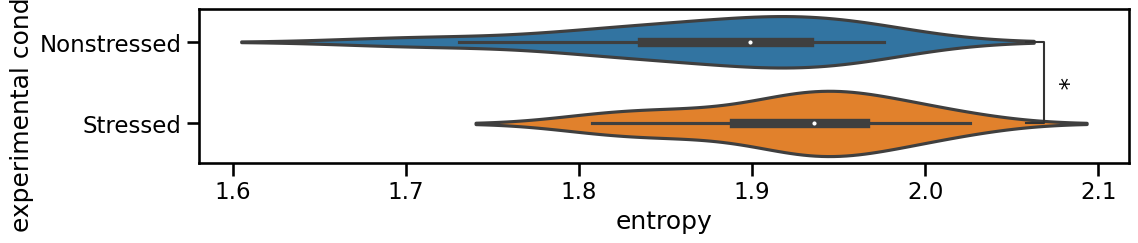

In [17]:
# Entropy plots
fig, ax = plt.subplots(1, 1, figsize=(12, 2))

deepof.visuals.plot_stationary_entropy(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    exp_condition="Condition",
    ax=ax,
)

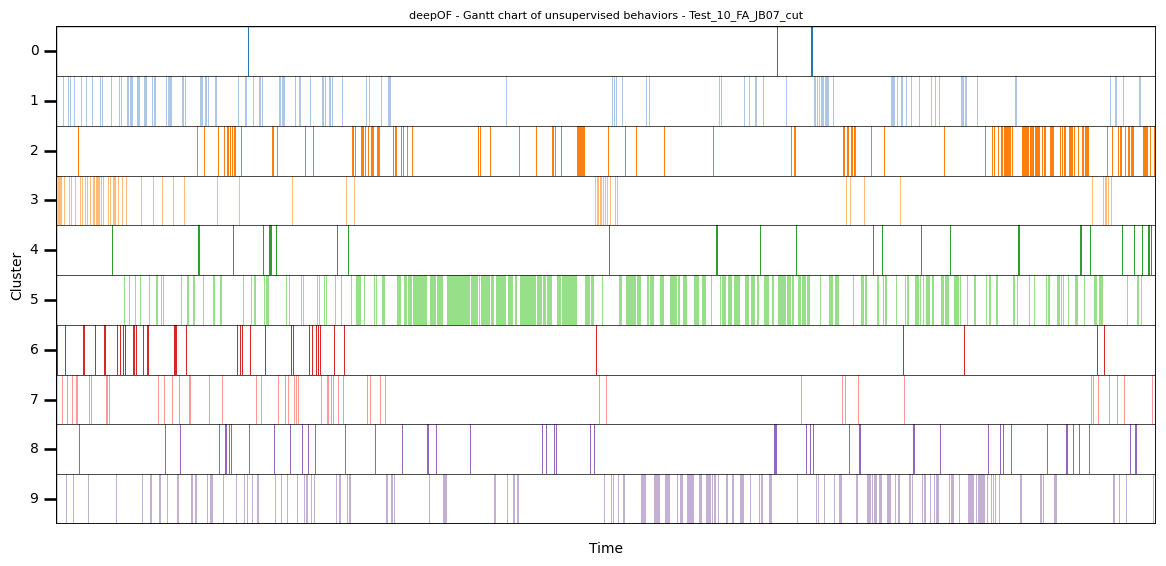

In [18]:
fig = plt.figure(figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_gantt(
    my_deepof_project,
    soft_counts=soft_counts,
    experiment_id="Test_10_FA_JB07_cut",
)

### Interpreting clusters using SHAP

In [19]:
%%time
csds_chunk_stats, hard_counts, sampled_breaks = deepof.post_hoc.annotate_time_chunks(
    deepof_project=my_deepof_project,
    soft_counts=soft_counts,
    breaks=breaks,
    #supervised_annotations=csds_OF_supervised_annotations,
    kin_derivative=1,
    window_size=13,
    include_distances=True,
    min_confidence=0.9,
    include_angles=True,
    include_areas=True,
    aggregate="mean",
    samples=1500,
)

CPU times: user 22.6 s, sys: 37.9 s, total: 1min
Wall time: 2min 5s


In [20]:
%%time
full_cluster_clf, cluster_gbm_performance, groups = deepof.post_hoc.train_supervised_cluster_detectors(
    csds_chunk_stats, hard_counts, sampled_breaks, n_folds=5, verbose=2,
)

Training cross-validated models for performance estimation...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Training on full dataset for feature importance estimation...
Done!
CPU times: user 1min 40s, sys: 4.26 s, total: 1min 44s
Wall time: 1min 14s


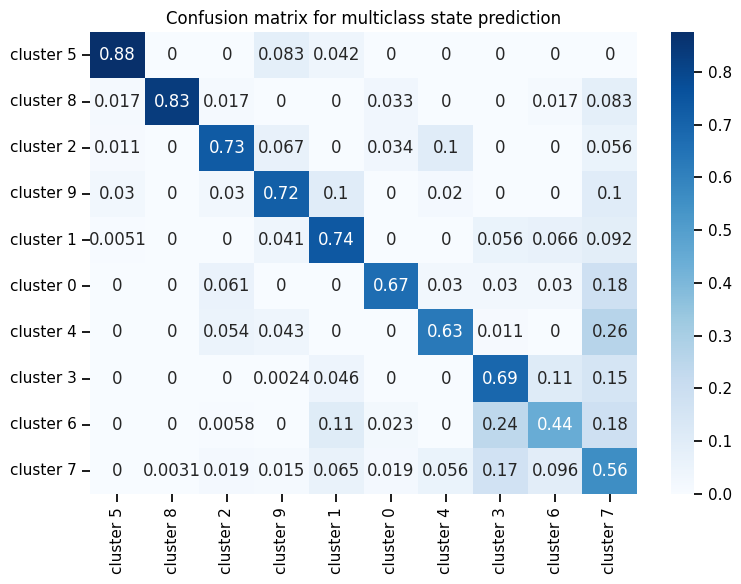

In [21]:
plt.figure(figsize=(8, 6))
sns.set_context("notebook")

deepof.visuals.plot_cluster_detection_performance(
    my_deepof_project,
    csds_chunk_stats,
    cluster_gbm_performance,
    hard_counts,
    groups,
    visualization="confusion_matrix",
)

/Users/lucas_miranda/Library/Caches/pypoetry/virtualenvs/deepof-qxwF8hwh-py3.9/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


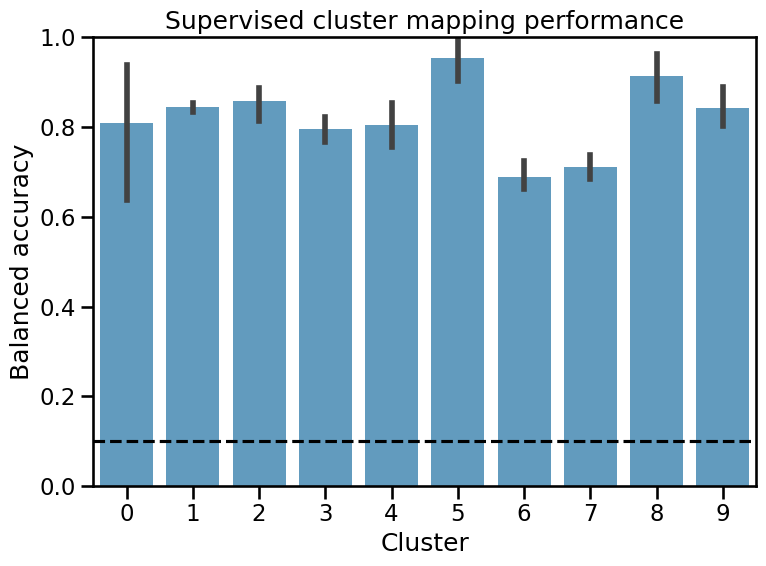

In [22]:
plt.figure(figsize=(8, 6))
sns.set_context("talk")

deepof.visuals.plot_cluster_detection_performance(
    my_deepof_project,
    csds_chunk_stats,
    cluster_gbm_performance,
    hard_counts,
    groups,
    visualization="balanced_accuracy",
)

In [58]:
shap_values, explainer, data_to_explain = deepof.post_hoc.explain_clusters(
    csds_chunk_stats, hard_counts, full_cluster_clf, samples=50
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [60]:
from matplotlib import colors as plt_colors
from ipywidgets import interact
import copy
import numpy as np

# Plot swarm plots per cluster
@interact()
def plot_shap_swarm_per_cluster(
    cluster=["all"] + list(range(10)), save=False,
):
    
    deepof.visuals.plot_shap_swarm_per_cluster(
        my_deepof_project, 
        data_to_explain, 
        shap_values, cluster, 
        save=save
    )

interactive(children=(Dropdown(description='cluster', options=('all', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value='al…

### Exporting cluster video snippets

In [ ]:
def output_cluster_video(cap, out, cluster_id, frame_mask, v_width, v_height, path):
    
    i=0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
            
        if frame_mask[i]:
            
            res_frame = cv2.resize(frame, [v_width, v_height])
            re_path = re.findall(".+/(.+)DLC", path)[0]
            
            if path is not None:
                cv2.putText(
                    res_frame,
                    re_path, 
                    (int(v_width * 0.3 / 10), int(v_height / 1.05)), 
                    cv2.FONT_HERSHEY_DUPLEX, 
                    0.75,
                    (255, 255, 255),
                    2,
                )
            
            out.write(res_frame)
            
        i+=1

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
def partition_video_per_unsupervised_cluster(
    video_paths,
    breaks,
    soft_counts,
    single_output=False,
    single_output_resolution=None,
    confidence_threshold=0.0,
    video_format="mp4",
):

    # Iterate over all clusters, and output a masked video for each
    for cluster_id in range(soft_counts[0].shape[1]):

        if single_output:
            out = cv2.VideoWriter(
                single_output + "_cluster={}.mp4".format(cluster_id),
                cv2.VideoWriter_fourcc(*"mp4v"),
                25.0,
                single_output_resolution,
            )

        for i, path in enumerate(video_paths):

            # Get hard counts and confidence estimates per cluster
            hard_counts = np.argmax(soft_counts[i], axis=1)
            confidence = np.max(soft_counts[i], axis=1)

            # Given a frame mask, output a subset of the given video to disk, corresponding to a particular cluster
            cap = cv2.VideoCapture(path)

            if not single_output:

                # Get width and height of current video
                v_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                v_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

                video_out = (
                    path[:-4]
                    + "_cluster={}".format(cluster_id)
                    + ".{}".format(video_format)
                )
                out = cv2.VideoWriter(
                    video_out,
                    cv2.VideoWriter_fourcc(*"mp4v"),
                    25.0,
                    (v_width, v_height),
                )

            else:
                v_width, v_height = single_output_resolution

            # Compute confidence mask
            confidence_mask = (hard_counts == cluster_id) & (
                confidence >= confidence_threshold
            )

            # Extend confidence mask using the corresponding breaks, to select and output all relevant video frames
            frame_mask = np.repeat(confidence_mask, breaks[i])

            output_cluster_video(
                cap,
                out,
                cluster_id,
                frame_mask,
                v_width,
                v_height,
                (path if single_output else None),
            )

In [ ]:
def output_unsupervised_annotated_video(
    video_paths, breaks, soft_counts, cluster_names={}
):

    # Get cluster assignment per frame
    hard_counts = np.argmax(soft_counts, axis=1)
    assignments_per_frame = np.repeat(hard_counts, breaks)

    # Given a frame mask, output a subset of the given video to disk, corresponding to a particular cluster
    cap = cv2.VideoCapture(video_path)

    # Get width and height of current video
    v_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    v_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_out = video_path[:-4] + "_unsupervised_annotated.mp4"
    out = cv2.VideoWriter(
        video_out, cv2.VideoWriter_fourcc(*"mp4v"), 25.0, (v_width, v_height)
    )

    i = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if ret == False:
            break

        cv2.putText(
            frame,
            "Cluster {}".format(assignments_per_frame[i]),
            (int(v_width * 0.3 / 10), int(v_height / 1.05)),
            cv2.FONT_HERSHEY_DUPLEX,
            0.75,
            (255, 255, 255),
            2,
        )
        out.write(frame)

        i += 1

    cap.release()
    cv2.destroyAllWindows()